# TO RUN : importS

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set(font_scale = 1.3, rc = {'figure.figsize':(10,6)})
sns.set_palette('colorblind')

# 1- FIRST STATISTICS
Here, we try to extract a few basic statistics to make sure we have the necessary data to perform the project. Indeed, after selecting the quotations of interests (the ones related to arms in the USA), we want to make sure these datas are sufficiently numerous to perform an actual study on the right to bear arms in the USA. We also want to check if our research questions are reasonnnable and can be solved from our data. <br>
<br>
First, we get a sense of the quantity of actual quotations speaking about arms, and we compute its share in the total quotes dataset of 2017.

### Load the data
The new dataset `quotes-2017-extended.json` can be loaded from here.

In [179]:
gunquotes = pd.read_json('data/quotes-2017-extended.json.bz2', lines=True, compression='bz2')
gunquotes

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,nationality,gender,occupation,age,ethnic_group,party,religion
0,2017-03-26-000661,"A big burglar, I never really knew him to carr...",Brian Andrews,"[Q2924842, Q4962982, Q4962983]",2017-03-26 17:01:19,1,"[[Brian Andrews, 0.7167], [Tony Fiore, 0.1666]...",[http://www.providencejournal.com/news/2017032...,E,[United States of America],[male],[singer],41.0,None,None,None
1,2017-08-31-083709,jumped off the balcony and got into a car in t...,Scott Jones,"[Q16240166, Q1839768, Q23024171, Q25189323, Q3...",2017-08-31 18:10:00,1,"[[Scott Jones, 0.6374], [None, 0.3361], [Rober...",[http://sfist.com/2017/08/31/hotel_roomshootou...,E,None,[male],[athletics competitor],23.0,None,None,None
2,2017-03-29-003312,a travesty with regards to not only the legisl...,Chris Cox,"[Q25206337, Q4919691, Q5106285, Q5106287, Q510...",2017-03-29 18:56:50,1,"[[Chris Cox, 0.8423], [None, 0.1517], [Asa Hut...",[http://www.guns.com/2017/03/29/sec-commish-gu...,E,None,[male],[horse trainer],NaN,None,None,None
3,2017-09-11-088873,similar rules for whether you can own a gun an...,Kris Kobach,[Q6437211],2017-09-11 22:17:52,2,"[[Kris Kobach, 0.5138], [John Lott, 0.3198], [...",[http://www.kansas.com/news/politics-governmen...,E,[United States of America],[male],[lawyer],55.0,None,[Republican Party],None
4,2017-08-10-034688,He keeps getting better each day at practice. ...,Ruffin McNeill,[Q7377923],2017-08-10 01:00:45,1,"[[Ruffin McNeill, 0.7703], [None, 0.2297]]",[http://newsok.com/marquise-overton-expected-t...,E,[United States of America],[male],"[head coach, American football player]",63.0,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58775,2017-07-25-041057,I do not know if such issue was discussed duri...,Bolaji Abdullahi,[Q52818781],2017-07-25 03:10:38,1,"[[Bolaji Abdullahi, 0.7587], [None, 0.2413]]",[http://www.thisdaylive.com/index.php/2017/07/...,E,[Nigeria],[male],"[politician, journalist]",52.0,[Yoruba people],[All Progressives Congress],None
58776,2017-11-30-045895,I think he will need surgery tomorrow and it's...,Mick McCarthy,"[Q40063430, Q437925]",2017-11-30 12:51:09,1,"[[Mick McCarthy, 0.8419], [None, 0.1023], [Kei...",[http://www.nottinghampost.com/sport/football/...,E,None,[male],[researcher],53.0,None,None,None
58777,2017-08-29-047666,I t's a movie about growing up and about gener...,Don Hahn,"[Q1072843, Q5292728]",2017-08-29 18:10:00,2,"[[Don Hahn, 0.8057], [None, 0.1943]]",[http://hellogiggles.com/reviews-coverage/movi...,E,[United States of America],[male],"[film producer, screenwriter, film director, a...",65.0,None,None,None
58778,2017-02-15-036379,"I yelled to my wife, `Go get the gun! '",Jim Gibbons,"[Q17411221, Q59228431, Q6195205, Q639207]",2017-02-15 16:37:10,1,"[[Jim Gibbons, 0.8571], [None, 0.1429]]",[http://freebeacon.com/issues/armed-homeowner-...,E,[United States of America],[male],[manager],NaN,None,None,None


In [180]:
nblines_gunquotes = gunquotes.shape[0]
nbtot_gunquotes = gunquotes['numOccurrences'].sum()
print(nblines_gunquotes)
print(nbtot_gunquotes)

58780
278020


In [181]:
# Data from the all 2017 quotes dataset :
nblines_totquotes = 26611588
nbtot_totquotes = 136326717

In [182]:
share_gunquotes = 100 * nblines_gunquotes / nblines_totquotes
sharetot_gunquotes = 100 * nbtot_gunquotes / nbtot_totquotes
print(share_gunquotes)
print(sharetot_gunquotes)

0.22088121911401906
0.20393654752208257


**Analysis :** <br>
The new dataset (with only selected quotes) contain 58 780 different quotes, some of which are quoted in several articles. Thus, there is a total number of 278 020 quotes found in the 2017 newspapers that are related to our topic. <br>
This represents a share of approximately 22 % of the total quotations of 2017. The size of the original 2017 dataset being very huge, it already represents a lot of data, for only one year. We can then deduce that we have enough data to perform our project.

### Share of American speakers  
As one of our research topic is the link between American speakers' characteristics and background (poltical party, age, genders...), it is interesting to compute the share of quotes by Americans in front of the total number of 'gun quotes'.

In [185]:
gunquotes['american'] = (gunquotes.nationality.apply(lambda x: (True if 'United States of America' in x else False) if x is not None and len(x) > 0 else False))
gunquotes

nb_american = gunquotes[(gunquotes['american']==True)].shape[0]
print(nb_american)
share_american = nb_american/nblines_gunquotes * 100
print(share_american)

nb_nationality = gunquotes[(gunquotes['nationality'].apply(lambda x: (True if x is not None and len(x) > 0 else False)))].shape[0]
share_american_nonone = nb_american/nb_nationality * 100
print(share_american_nonone)

nb_american = gunquotes[(gunquotes['american']==True)].numOccurrences.sum()
share_american_numOcc = nb_american/nbtot_gunquotes * 100
print(share_american_numOcc)

28134
47.8632187818986
58.47484047970403
58.91518595784476


**Analysis :**  
We know that at least 48% of the speakers speaking about guns are Americans. This seems low but we have to take into account that for a lot of speakers, the nationality could not be found. Indeed, if we only consider the speakers for which we know the nationality, 58% of them are American.  
  
Moreover, it is possible that the quotations by American speakers are quoted by several newspapers, more times than the quotes of non-Americans speakers. Indeed, if we duplicate the quotes by the number of repetition of them, we obtain 59% of quotes attributed to Americans.  
  
Again, the data are quite numerous, so it will be possible to perform some study on the American speakers only.

### A first timeline for 2017

In [102]:
# Useful functions for the following plots

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

#### 'Gun quotes' timeline per month

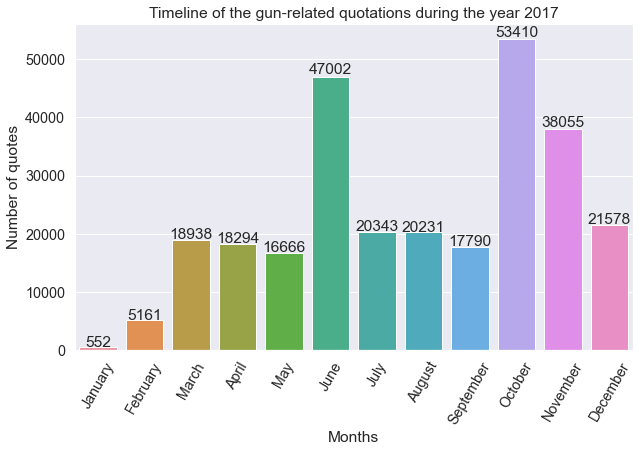

In [167]:
## Plot of the nb of quotes related to guns in function of the month

gunquotes['dateWithoutTime'] = gunquotes['date'].dt.normalize()

ax = sns.barplot(x=np.linspace(1,12,12), y=gunquotes.groupby(gunquotes['dateWithoutTime'].dt.month).numOccurrences.sum())#, data=gunquotes)
sns.set_color_codes("colorblind")
ax.set_xlabel('Months')
ax.set_ylabel('Number of quotes')
ax.set_title('Timeline of the gun-related quotations during the year 2017')
ax.set_xticklabels(labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks(rotation=60)
show_values(ax)
plt.show()


**Analysis :** <br>
The barplot reveals an unexpected big amount of quotations speaking about guns in the months of June and October. One can guess that this is due to an event that occured in this month. Indeed, for example the amounts of quotes in October can be explianed by the Las Vegas shooting of the 1st of October. To verfiy this guess we will look further at the distribution of the quotes in thess 2 months.

#### Zoom on the month of June

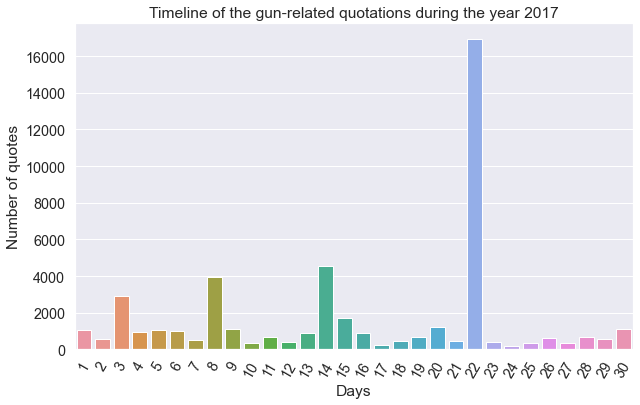

In [113]:
## Plot of the nb of quotes related to guns in function of the date : zoom on JUNE

june = gunquotes[(gunquotes['date'].dt.month == 6)]

ax = sns.barplot(x=np.linspace(1,30,30, dtype='int'), y=june.groupby(june['dateWithoutTime']).numOccurrences.sum())#, data=gunquotes)
sns.color_palette("tab10")
ax.set_xlabel('Days')
ax.set_ylabel('Number of quotes')
ax.set_title('Timeline of the gun-related quotations during the year 2017')
plt.xticks(rotation=60)
# show_values(ax)
plt.show()

In [105]:
gunquotes[(gunquotes['date'].dt.month == 6)]
june[(june['date'].dt.day==22)].numOccurrences.sum()
june[(june['date'].dt.day!=22)].numOccurrences.mean()

5.461748137379611

In [106]:
june_22 = june[(june['date'].dt.day==22)]
june_22.quotation.iloc[1]
# june_22[(june_22.quotation.str.contains('pedophilia'))].numOccurrences.sum()
june[(june.quotation.str.contains('sentenced'))].quotation
# june_22[(june_22.quotation.str.contains('prison'))].numOccurrences.sum()
gunquotes[(gunquotes.quotation.str.contains('Last month, Joshua Brandon Vallum'))]
# gunquotes.iloc[19414].quotation
# gunquotes.iloc[31416].urls
# june[(june.quotation.str.contains('baseball'))].numOccurrences.sum()
# june[(june.quotation.str.contains('baseball'))].iloc[0].quotation

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,nationality,gender,occupation,age,ethnic_group,party,religion,american,dateWithoutTime


**Analysis :**  
The timeline for June is quite interesting. There is a big peak in the quantity of quotes for the day 22 : 16 946 quotes published in the newspapers, while the other days have a mean of approximately 8 quotes. We were quite supprised by this result as we didn't remember of any event related to guns in this period. After a few reaserch on the web, we found that the 22th of June 2017 corresponds to the day that the 'Pizzagate' murderer (4th December 2016) was sentenced to 4 years of prison. We think that the big amount of quotes for this day, is indeed related to this sentence since a lot of these quotation contains key words about this topic.  
Sources : https://www.nytimes.com/2017/06/22/us/pizzagate-attack-sentence.html ; https://en.wikipedia.org/wiki/Pizzagate_conspiracy_theory   

There was also a shooting during a baseball practice of the Congressional Baseball Game for Charity on the 14th of June 2017. This explains the also quite large amount of data for this day and the large amount of quotations (201) containing the word *"baseball"*.  
Source : https://en.wikipedia.org/wiki/Congressional_baseball_shooting

#### Zoom on the month of October

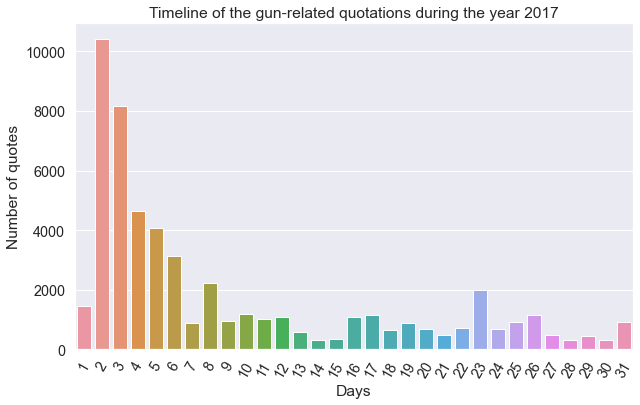

In [114]:
## Plot of the nb of quotes related to guns in function of the date : zoom on OCTOBER

october = gunquotes[(gunquotes['date'].dt.month == 10)]
# nb = october.groupby(october['dateWithoutTime']).numOccurrences.sum()
# print(nb.sum())

ax = sns.barplot(x=np.linspace(1,31,31, dtype='int'), y=october.groupby(october['dateWithoutTime']).numOccurrences.sum())#, data=gunquotes)
sns.color_palette("tab10")
ax.set_xlabel('Days')
ax.set_ylabel('Number of quotes')
ax.set_title('Timeline of the gun-related quotations during the year 2017')
#ax.set_xticklabels(labels=labs)
plt.xticks(rotation=60)
# show_values(ax)
plt.show()


**Analysis :**  
Most of the quotations of the mmonth of October were found in articles of the 2nd of October, the day after the mass shooting of Las Vegas. This thus confirms our guess that these articles spoke about this event. The following days, also show a higher amount of quotations, revealing that the medias continued to talk about the tragedy in the following days.

#### 'Gun quotes' timeline per month for American and non-American speakers

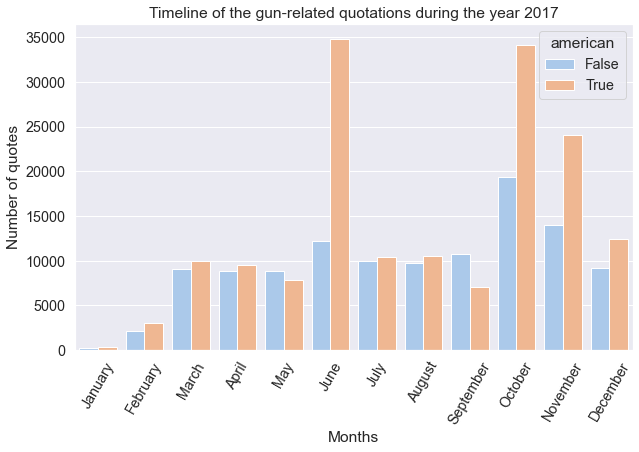

In [199]:
def process_chunk(chunk):
    df_temp = chunk.loc[chunk.index.repeat(chunk.numOccurrences)]
    ax = sns.countplot(x = df_temp.date.dt.month, data = df_temp, hue='american', palette='pastel')
    sns.set_color_codes("colorblind")
    ax.set_xlabel('Months')
    ax.set_ylabel('Number of quotes')
    ax.set_title('Timeline of the gun-related quotations during the year 2017')
    ax.set_xticklabels(labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
    plt.xticks(rotation=60)
#     show_values(ax)
    plt.show()

process_chunk(gunquotes)

**Analysis :**  
The timeline allows to see the difference between American and non-american speakers quotations in time. We obtained the same conclusions as above, with the months of June and October having a particularly big amount of quotes speaking about guns. However, we can see that the amount of quotes by American speakers are more important for almst each month. This confirm that it is relevant to focus on the American speakers for some of our research axis.

# 2- MATCHING OF THE DATASET FOR SENTIMENT ANALYSIS

### Matching of the dataset 

### Sentiment analysis

# Conclusions on the following of the project  
TO COMPLETE